# Project N°1 
Make by:

Jose Luis Hincapie Bucheli - 2125340

Carlos Andrés Hernández - 2125653

## Require Libraries

In [70]:
%%writefile requirements.txt
numpy==1.25.2
prettytable
sympy==1.12
opencv-python==4.8.1.78
matplotlib==3.8.2

Overwriting requirements.txt


In [71]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Discretization of the initial problem.

In [72]:
import numpy as np
#from auxiliares import limpiar_pantalla
from prettytable import PrettyTable 

# Se define la malla a tratar con las condiciones iniciales

v_0 = 1 # Velocidad inicial en x

mallax = np.array(
    [[1,  0,   0,   0,   0,   0,   0,  0],
    [1, "w1", "w2", 0, 0, "w3", "w4", 0],
    [1, "w5", "w6", 0, 0, "w7", "w8", 0],
    [1, "w9", "w10", "w11", "w12", "w13", "w14", 0],
    [1, "w15", "w16", 0, 0, "w17", "w18", 0],
    [1, "w19", "w20", 0, 0, "w21", "w22", 0],
    [1,  0,   0,   0,   0,   0,   0,  0]])

mallay = np.array(
    [[0,  0,   0,   0,   0,   0,   0,  0],
    [0, "w1", "w2", 0, 0, "w3", "w4", 0],
    [0, "w5", "w6", 0, 0, "w7", "w8", 0],
    [0, "w9", "w10", "w11", "w12", "w13", "w14", 0],
    [0, "w15", "w16", 0, 0, "w17", "w18", 0],
    [0, "w19", "w20", 0, 0, "w21", "w22", 0],
    [0,  0,   0,   0,   0,   0,   0,  0]])


r_matrix = np.zeros((22, 23), dtype=int) # Almacenar los resultados finales de la discretización

# Funtion that reshape results in a finish matrix the last colum are the numeric values

def fixMatrix(values, count):
    global r_matrix
    acum = 0
    for value in values:
        if value[0] == 'w':
            match np.where(values == value)[0][0]:
                case 0:
                    r_matrix[count][int(value[1:])-1] = 1
                case 1:
                    r_matrix[count][int(value[1:])-1] = -8
                case 2:
                    r_matrix[count][int(value[1:])-1] = 3
                case 3:
                    r_matrix[count][int(value[1:])-1] = 3
                case 4:
                    r_matrix[count][int(value[1:])-1] = 1
        else:
            match np.where(values == value)[0][0]:
                case 0:
                    acum += int(value)*1
                case 1:
                    acum += int(value)*-8
                case 2:
                    acum += int(value)*3
                case 3:
                    acum += int(value)*3
                case 4:
                    acum += int(value)*1
    r_matrix[count][-1] = acum


# Funtion that find the positions needed in navier-stokes using Finite differences
def discretization(malla):
    count = 0
    for row in range(7):
        for colum in range(8):
            if malla[row][colum][0] == 'w':
                temp = np.array([malla[row][colum+1], malla[row][colum],
                                malla[row][colum-1], malla[row-1][colum], malla[row+1][colum]])
                fixMatrix(temp, count)
                count += 1
                

if __name__ == "__main__":
    discretization(mallax)
    
    column_names = [f"W{i}" for i in range(1, 24)]
    column_names[-1] = "T.I"
    
    # Create a table to format de r_matrix table
    table = PrettyTable()
    table.field_names = [""] + column_names 
    
    for i, row in enumerate(r_matrix, start=1):
        equation_label = f"Ecuación {i}"
        row_as_strings = [str(value) for value in row]
        table.add_row([equation_label] + row_as_strings)
        

    print(table)
    


+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|             | W1 | W2 | W3 | W4 | W5 | W6 | W7 | W8 | W9 | W10 | W11 | W12 | W13 | W14 | W15 | W16 | W17 | W18 | W19 | W20 | W21 | W22 | T.I |
+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|  Ecuación 1 | -8 | 1  | 0  | 0  | 1  | 0  | 0  | 0  | 0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  3  |
|  Ecuación 2 | 3  | -8 | 0  | 0  | 0  | 1  | 0  | 0  | 0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  Ecuación 3 | 0  | 0  | -8 | 1  | 0  | 0  | 1  | 0  | 0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  Ecuación 4 | 0  | 0  | 3  | -8 | 0  | 0  | 0  | 1  | 0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0 

# Second Part Of The Solution


To solve the problem of finding the solution for the parameter variables, use Successive Over-Relaxation (SOR) to aproch the solution faster.

- First check if the matrix is strictly diagonally dominant

In [73]:
'''
Funtion that checks if a matrix is diagonally dominant
X = Matrix
'''
def dd(X):
    M = np.delete(X,-1,1)
    D = np.diag(np.abs(M)) # Find diagonal coefficients
    S = np.sum(np.abs(M), axis=1) - D # Find row sum without diagonal
    if np.all(D >= S):
        print( 'matrix is diagonally dominant')
    else:
        print ('NOT diagonally dominant')

dd(r_matrix)

matrix is diagonally dominant


In [74]:
'''
Calculate the determinant of the matrix
'''
r_matrix_ni = np.delete(r_matrix,-1,1)

determinant = np.linalg.det(r_matrix_ni)
if determinant !=0:
    print("The matrix is invertible")
else:
    print("The matrix is not invertible")


The matrix is invertible


Now that the conditions are meet and we know the method will converge in a solution we use SOR


In [75]:
'''
Funtion that use jacobi method in a especific row
R = Row to apply jacobi
S = array of initial solutions for the row
nn = interation value, in other words for which variable we want to apply jacobi.
'''
def jacobi(R,S,nn):
    acum =0
    c = -R[-1]/R[nn]
   # print(f"{-R[-1]}/{R[nn]} = {c}")
    acum += c
    for i in range(len(R)-1):
        #print(f"{-R[i]} / {R[nn]}*{S[i]} = {(-R[i]/ R[nn]) * S[i]}")
        acum+= ( (-R[i]/ R[nn]) * S[i] ) if i != nn else 0
    return acum

In [76]:
jacobi(r_matrix[-1],np.zeros(22),21)

0.0

In [77]:
'''
Funtion that checks if the given solutions satisfy the tolerance
S = Preview solution
NS = New Solution
tol = tolerance
'''
def check_tolerance(S, NS, tol):
    # Infinity Norm
    error = np.linalg.norm(NS - S, np.inf) / np.linalg.norm(NS, np.inf)
    print("Error: ", error)
    if error > tol:
        return True
    else:
        return False
    

In [78]:

'''
Funtion that use Successive Over-Relaxation in an especific matrix.
M = Matrix of coeficients with idependent vector  
omega = stride for faster convergence.
tol = tolerance
'''

def SOR(M,omega,tol):
    l = len(M)
    S= np.zeros(l)
    OS = np.copy(S)
    acum = 0
    for i in range(l):
        c = -M[i][-1]/M[i][i]
        S[i] = c    
    while check_tolerance(OS,S,tol):
        acum += 1
        OS = np.copy(S)
        for i in range(l):
            S[i] = (1 - omega) * S[i] + omega * jacobi(M[i],S,i)
    print(f"Number of iterations: {acum}")
    return S


lineal_solution = SOR(r_matrix,1.2,1e-6)
print("---------------")
print(lineal_solution)

Error:  1.0
Error:  0.7604665053128321
Error:  0.12072251780308257
Error:  0.023012446073350724
Error:  0.008076070609391089
Error:  0.0018818317020968577
Error:  0.0003946129227636158
Error:  7.308228557459871e-05
Error:  2.1896547785269112e-05
Error:  2.4586200677768674e-06
Error:  8.580235918316235e-07
Number of iterations: 10
---------------
[0.494523 0.239214 0.000871 0.000949 0.716968 0.43014  0.006019 0.004981
 0.822038 0.572573 0.22594  0.089797 0.040556 0.018944 0.852828 0.598112
 0.018056 0.014943 0.758397 0.508691 0.007839 0.008543]


In [79]:
lineal_solution = SOR(r_matrix,1.2,1e-6)
print("---------------")
print(lineal_solution)

Error:  1.0
Error:  0.7604665053128321
Error:  0.12072251780308257
Error:  0.023012446073350724
Error:  0.008076070609391089
Error:  0.0018818317020968577
Error:  0.0003946129227636158
Error:  7.308228557459871e-05
Error:  2.1896547785269112e-05
Error:  2.4586200677768674e-06
Error:  8.580235918316235e-07
Number of iterations: 10
---------------
[0.494523 0.239214 0.000871 0.000949 0.716968 0.43014  0.006019 0.004981
 0.822038 0.572573 0.22594  0.089797 0.040556 0.018944 0.852828 0.598112
 0.018056 0.014943 0.758397 0.508691 0.007839 0.008543]


## Conjugate Gradient Method

Applying this method allow to find the gradient, with shows the direction for which the funtions increase or decrease.

To use this method the matrix must be symmetric and positive

In [80]:


def symmetric(M):
    Mt = np.transpose(M) #Transpose matrix
    #print(np.equal(M,Mt)) #shows which elements of are not equal to the intial matrix (M)
    return np.array_equal(M,Mt)

In [81]:
print(f"It's the matrix symmetric? {symmetric(r_matrix_ni)}")

It's the matrix symmetric? False


In [82]:
def possitive(M):
    return np.all(np.linalg.eigvals(M)>0)

In [83]:
print(f"It's the matrix possitive? {possitive(r_matrix_ni)}")

It's the matrix possitive? False


Since the conditions are not met, we can't use Conjugate Gradient

----

# Newton Raphson Metohd for non-linear systems

Generating the system of nonlinear equations

In [84]:

# We want to represent nonlinear equations, which using Navier-Stokes would be of the form: 
# 2Vx(i+1,j) + 2Vx(i-1,j) + 2Vx(i,j+1 + 2Vx(i,j-1 - 8Vx(i,j - Vx(i,j)Vx(i+1,j + Vx(i,j)Vx(i-1,j - Vx(i,j)Vx(i,j+1 + Vx(i,j)Vx(i,j-1) = 0

from sympy import Symbol,symbols,diff
import numpy as np

mallax = np.array(
    [[1,  0,   0,   0,   0,   0,   0,  0],
    [1, "w1", "w2", 0, 0, "w3", "w4", 0],
    [1, "w5", "w6", 0, 0, "w7", "w8", 0],
    [1, "w9", "w10", "w11", "w12", "w13", "w14", 0],
    [1, "w15", "w16", 0, 0, "w17", "w18", 0],
    [1, "w19", "w20", 0, 0, "w21", "w22", 0],
    [1,  0,   0,   0,   0,   0,   0,  0]])

mallay = np.array(
    [[0,  0,   0,   0,   0,   0,   0,  0],
    [0, "w1", "w2", 0, 0, "w3", "w4", 0],
    [0, "w5", "w6", 0, 0, "w7", "w8", 0],
    [0, "w9", "w10", "w11", "w12", "w13", "w14", 0],
    [0, "w15", "w16", 0, 0, "w17", "w18", 0],
    [0, "w19", "w20", 0, 0, "w21", "w22", 0],
    [0,  0,   0,   0,   0,   0,   0,  0]])

# These lists will be used to store the nonlinear equations and corresponding symbolic variables.
equations_x = []
vars_x = []

equations_y = []
vars_y = []

# This function takes a position (i, j) in the matrix grid and returns a symbol if the entry starts with "w" (indicating a variable) or an integer if not.
def determinate(i, j, grid):
    if grid[i, j][0] == "w":
        # variable
        return Symbol(grid[i, j])
    else:
        # number
        return int(grid[i, j])

# This function generates nonlinear equations based on the elements of the grid matrix. It iterates through the rows and columns of the matrix, and for each non-zero element, constructs a nonlinear equation and adds both the equation and the symbolic variable to the corresponding lists.
def generate_nonlinear_equations(grid,equations,vars):
    for i in range(1, 6):
        for j in range(1, 7):
            # Construct the nonlinear equation
            value = determinate(i, j, grid)
            if value != 0:
                equation = (2 * determinate(i + 1, j, grid) + 2 * determinate(i - 1, j, grid) + 2 * determinate(i, j + 1, grid) + 2 * determinate(i, j - 1, grid) 
                            - 8 * determinate(i, j, grid) - determinate(i, j, grid) * determinate(i + 1, j, grid) + determinate(i, j, grid) * determinate(i - 1, j, grid) 
                            - determinate(i, j, grid) * determinate(i, j + 1, grid) + determinate(i, j, grid) * determinate(i, j - 1, grid)
                           )
                equations.append(equation)
                vars.append(value)

# Call the function with the grid matrix
generate_nonlinear_equations(mallax,equations_x,vars_x)
generate_nonlinear_equations(mallay,equations_y,vars_y)



In [85]:
# Print the nonlinear equations and corresponding variables
table_x = PrettyTable()
table_x.field_names = ['Equation']
for eq in zip(equations_x):
    table_x.add_row([str(eq)])
print("Nonlinear Equations for Vx:")
print(table_x)

Nonlinear Equations for Vx:
+--------------------------------------------------------------------------------+
|                                    Equation                                    |
+--------------------------------------------------------------------------------+
|                   (-w1*w2 - w1*w5 - 7*w1 + 2*w2 + 2*w5 + 2,)                   |
|                     (w1*w2 + 2*w1 - w2*w6 - 8*w2 + 2*w6,)                      |
|                     (-w3*w4 - w3*w7 - 8*w3 + 2*w4 + 2*w7,)                     |
|                     (w3*w4 + 2*w3 - w4*w8 - 8*w4 + 2*w8,)                      |
|            (w1*w5 + 2*w1 - w5*w6 - w5*w9 - 7*w5 + 2*w6 + 2*w9 + 2,)            |
|            (-w10*w6 + 2*w10 + w2*w6 + 2*w2 + w5*w6 + 2*w5 - 8*w6,)             |
|            (-w13*w7 + 2*w13 + w3*w7 + 2*w3 - w7*w8 - 8*w7 + 2*w8,)             |
|            (-w14*w8 + 2*w14 + w4*w8 + 2*w4 + w7*w8 + 2*w7 - 8*w8,)             |
|         (-w10*w9 + 2*w10 - w15*w9 + 2*w15 + w5*w9 + 2*w5 

In [86]:
print(vars_x)

[w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14, w15, w16, w17, w18, w19, w20, w21, w22]


In [87]:
table_y = PrettyTable()
table_y.field_names = ['Equation']
for eq in zip(equations_y):
    table_y.add_row([str(eq)])
print("Nonlinear Equations for Vy:")
print(table_y)

Nonlinear Equations for Vy:
+--------------------------------------------------------------------------------+
|                                    Equation                                    |
+--------------------------------------------------------------------------------+
|                     (-w1*w2 - w1*w5 - 8*w1 + 2*w2 + 2*w5,)                     |
|                     (w1*w2 + 2*w1 - w2*w6 - 8*w2 + 2*w6,)                      |
|                     (-w3*w4 - w3*w7 - 8*w3 + 2*w4 + 2*w7,)                     |
|                     (w3*w4 + 2*w3 - w4*w8 - 8*w4 + 2*w8,)                      |
|              (w1*w5 + 2*w1 - w5*w6 - w5*w9 - 8*w5 + 2*w6 + 2*w9,)              |
|            (-w10*w6 + 2*w10 + w2*w6 + 2*w2 + w5*w6 + 2*w5 - 8*w6,)             |
|            (-w13*w7 + 2*w13 + w3*w7 + 2*w3 - w7*w8 - 8*w7 + 2*w8,)             |
|            (-w14*w8 + 2*w14 + w4*w8 + 2*w4 + w7*w8 + 2*w7 - 8*w8,)             |
|           (-w10*w9 + 2*w10 - w15*w9 + 2*w15 + w5*w9 + 2*w

In [88]:
print(vars_y)

[w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14, w15, w16, w17, w18, w19, w20, w21, w22]


Calculate the jacobian matrix for the system of nonlinear equations

In [89]:
# Define a function to calculate the Jacobian matrix for a system of nonlinear equations.

def jacobian(equations, variables):
    # Get the number of equations and variables
    rows = len(equations)
    cols = len(variables)

    # Initialize the Jacobian matrix with zeros
    J = [[0] * cols for _ in range(rows)]

    # Iterate through each equation and variable to calculate partial derivatives
    for i, eq in enumerate(equations):
        for j, var in enumerate(variables):
            # Calculate the partial derivative of the equation with respect to the variable
            J[i][j] = diff(eq, var)

    # Return the calculated Jacobian matrix
    return J

In [90]:
# x_(k+1) = x_k - (J(x_k))^-1 * f(x_k)
#  J(x_k) = (dF(x_k)/dx_k))

# (J(x_k))*x_(k+1) = (J(x_k))*x_k - f(x_k) => Without Jacobian Inverse

# Define symbolic variables
x1, x2 = symbols('x1 x2')

# Define the equations
f1 = x1**2 - x2**2 + 2*x2
f2 = 2*x1 + x2**2 - 6

# Define the Jacobian
J = jacobian([f1, f2], [x1, x2])

# Display the Jacobian
print("Jacobian:")
print(J)

Jacobian:
[[2*x1, 2 - 2*x2], [2, 2*x2]]


Evaluate symbolic functions

In [91]:
# Evaluate a symbolic function for a given set of variables and values.

def evalFunction(function, vars, values):
    # Initialize the result with the given function
    result = function

    # Number of variables
    numVars = len(vars)

    # Iterate through each variable and substitute its value in the function
    for i in range(numVars):
        result = result.subs(vars[i], values[i])

    # Convert the result to a float and return
    return float(str(result))


In [92]:
result = evalFunction(equations_x[0], vars_x, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
print(result)

2.0


In [93]:
result = evalFunction(equations_y[0], vars_y, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
print(result)

-1.0


In [94]:
# Evaluate a list of symbolic functions for a given set of variables and values.

def evalFunctionsAndValues(functions, vars, values):
    # List to store the results of evaluated functions
    results = []

    # Number of variables
    numVars = len(vars)

    # Iterate through each function in the list
    for func in functions:
        # Initialize the result with the current function
        result = func
        
        # Iterate through each variable and substitute its value in the function
        for i in range(numVars):
            result = result.subs(vars[i], values[i])
        
        # Append the evaluated result to the list
        results.append(float(str(result)))

    # Return the list of evaluated function results
    return results


In [95]:
functions_evaluated = evalFunctionsAndValues(equations_x, vars_x, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
print(functions_evaluated)


[2.0, -12.0, -35.0, -30.0, -71.0, -32.0, -134.0, -38.0, -181.0, -116.0, -66.0, -72.0, -160.0, 8.0, -405.0, 42.0, -474.0, 124.0, -156.0, 610.0, -195.0, 760.0]


Evaluate the jacobian matrix

In [96]:
# Evaluate the Jacobian matrix of a system of equations at a given point.

def evaluateJacobian(jacobian_matrix, symbols, numerical_values):
    # List to store the evaluated Jacobian matrix
    evaluated_jacobian = []
    # Iterate through each row in the Jacobian matrix
    for row in jacobian_matrix:
        # Evaluate each partial derivative in the row using given values
        row_evaluated = evalFunctionsAndValues(row, symbols, numerical_values)
        
        # Append the row of evaluated partial derivatives to the result
        evaluated_jacobian.append(row_evaluated)

    # Return the complete evaluated Jacobian matrix
    return evaluated_jacobian


Determine whether the Newton-Raphson method should stop at a given iteration, based on the evaluation of the equations of the system at a candidate solutionº.

In [97]:
def shouldStop(equations, variables, current_solution, tolerance):
    # Evaluate the system of equations at the current solution
    evaluations = np.array(evalFunctionsAndValues(equations, variables, current_solution))

    # Calculate the norm (magnitude) of the vector of equation evaluations
    norm = np.linalg.norm(evaluations)

    # Check if the norm is below the specified tolerance
    if norm < tolerance:
        # If the norm is below tolerance, consider the solution accurate enough
        return True
    else:
        # If the norm is not below tolerance, more iterations are needed
        return False


In [98]:
# Define variables and equations
x, y = symbols('x y')
equations = [x**2 + y**2 - 25, x + y - 7]

# Initial guess for the solution
initial_solution = [1, 6]

# Tolerance for stopping criteria
tolerance = 1e-6

# Check if the solution is accurate enough
result = shouldStop(equations, [x, y], initial_solution, tolerance)

print(result)


False


Newton-Raphson method

In [99]:
tolerance = 1e-3
initAproximationVX = [0]*len(vars_x)
initAproximationVY = [0]*len(vars_y)

In [100]:
def newtonRaphson(system_equations, variables, initial_approximation, tolerance):
    # Initialize the solution with the initial approximation
    current_solution = initial_approximation
    # Calculate the Jacobian matrix of the system
    jacobian_matrix = jacobian(system_equations, variables)
    # Initialize the iteration counter
    iterations = 0
    while True:
        # Evaluate the Jacobian matrix at the current solution
        jacobian_evaluated = np.array(evaluateJacobian(jacobian_matrix, variables, current_solution)) 
        # Calculate the inverse of the Jacobian matrix
        jacobian_inv = np.linalg.inv(jacobian_evaluated)
        # Evaluate the system functions at the current solution
        system_evaluations = np.array(evalFunctionsAndValues(system_equations, variables, current_solution))
        # Calculate the next approximation using the Newton-Raphson method
        # x_(k+1) = x_k - (J(x_k))^-1 * f(x_k)
        next_solution = np.array(current_solution) - (jacobian_inv.dot(system_evaluations))
        # Check the convergence conditions
        if iterations >= 100 or shouldStop(system_equations, variables, next_solution, tolerance):
            return next_solution
        else:
            # Update the current solution with the new approximation
            current_solution = next_solution
        # Increment the iteration counter
        iterations += 1


In [101]:
solution_vx = newtonRaphson(equations_x, vars_x, initAproximationVX,tolerance)

solution_vy = newtonRaphson(equations_y, vars_y, initAproximationVY,tolerance)

In [102]:

# Create a table to display the solutions
table = PrettyTable()
table.field_names = ['Variable', 'Solution']

# Add rows to the table with each variable and its solution
for var, sol in zip(vars_x, solution_vx):
    table.add_row([str(var), sol])

# Print the table
print("Solution for Vx:")
print(table)

Solution for Vx:
+----------+-----------------------+
| Variable |        Solution       |
+----------+-----------------------+
|    w1    |   0.4800783093023615  |
|    w2    |  0.21266834401399803  |
|    w3    | 0.0011688907451201764 |
|    w4    |  0.000841288135277563 |
|    w5    |   0.6824740013922657  |
|    w6    |  0.35756839289724873  |
|    w7    |  0.003837009054196455 |
|    w8    |  0.002196694135354569 |
|    w9    |   0.7729767160071275  |
|   w10    |  0.45675441437112196  |
|   w11    |  0.13003793768806357  |
|   w12    |  0.03604312269242103  |
|   w13    |  0.012007459545662548 |
|   w14    |  0.004107852805995208 |
|   w15    |   0.7806708220407035  |
|   w16    |  0.43796197421814237  |
|   w17    |   0.0038502021148202  |
|   w18    | 0.0022026072517890662 |
|   w19    |   0.6407493717809911  |
|   w20    |   0.3117082382225878  |
|   w21    | 0.0011741266439800465 |
|   w22    | 0.0008445399472397637 |
+----------+-----------------------+


In [103]:

# Create a table to display the solutions
tabley = PrettyTable()
tabley.field_names = ['Variable_Y', 'Solution']

# Add rows to the table with each variable and its solution
for var, sol in zip(vars_y, solution_vy):
    tabley.add_row([str(var), sol])

# Print the table
print("Solution for Vy:")
print(tabley)


Solution for Vy:
+------------+----------+
| Variable_Y | Solution |
+------------+----------+
|     w1     |   0.0    |
|     w2     |   0.0    |
|     w3     |   0.0    |
|     w4     |   0.0    |
|     w5     |   0.0    |
|     w6     |   0.0    |
|     w7     |   0.0    |
|     w8     |   0.0    |
|     w9     |   0.0    |
|    w10     |   0.0    |
|    w11     |   0.0    |
|    w12     |   0.0    |
|    w13     |   0.0    |
|    w14     |   0.0    |
|    w15     |   0.0    |
|    w16     |   0.0    |
|    w17     |   0.0    |
|    w18     |   0.0    |
|    w19     |   0.0    |
|    w20     |   0.0    |
|    w21     |   0.0    |
|    w22     |   0.0    |
+------------+----------+


# Third Part: Vizualization with interpolation methos

## Splines bi-cúbicos



In [104]:
# This function is used to solve a matrix by replacing the calculated values with the Jacobi over-relaxation method.
# It takes a matrix and a list of Jacobi over-relaxation values as input, and returns the matrix with the updated values.
def solve_matrix(matrix, jacobi_over_relaxation_values):
    # Get the dimensions of the matrix
    dim = matrix.shape
    result = []
    actual_value = 0
    
    # Set NumPy print options
    np.set_printoptions(suppress=True, precision=6)

    # Replace the calculated values in the matrix, obtaining the matrix with the updated values.
    for i in range(dim[0]):
        row = []
        for j in range(dim[1]):
            if matrix[i, j][0] == "w":
                row.append(jacobi_over_relaxation_values[actual_value])
                actual_value += 1
            else:
                row.append(int(matrix[i, j]))
        result.append(row)

    return np.array(result)


In [105]:

# Print the matrix with the calculated values
matrix_values = solve_matrix(mallax, lineal_solution)
print("Matrix values (in x)")
table = PrettyTable()

# Get the number of columns in the matrix
num_columns = matrix_values.shape[1]

# Add column names to the table
table.field_names = [''] + [f'Col{col+1}' for col in range(num_columns)]

# Add rows to the table with row names
for i, row in enumerate(matrix_values, start=1):
    # Round each element to 6 decimal places for better display
    rounded_row = [f'Fil{i}'] + [round(element, 6) for element in row]
    table.add_row(rounded_row)

# Print the table
print(table)

Matrix values (in x)
+------+------+----------+----------+---------+----------+----------+----------+------+
|      | Col1 |   Col2   |   Col3   |   Col4  |   Col5   |   Col6   |   Col7   | Col8 |
+------+------+----------+----------+---------+----------+----------+----------+------+
| Fil1 | 1.0  |   0.0    |   0.0    |   0.0   |   0.0    |   0.0    |   0.0    | 0.0  |
| Fil2 | 1.0  | 0.494523 | 0.239214 |   0.0   |   0.0    | 0.000871 | 0.000949 | 0.0  |
| Fil3 | 1.0  | 0.716968 | 0.43014  |   0.0   |   0.0    | 0.006019 | 0.004981 | 0.0  |
| Fil4 | 1.0  | 0.822038 | 0.572573 | 0.22594 | 0.089797 | 0.040556 | 0.018944 | 0.0  |
| Fil5 | 1.0  | 0.852828 | 0.598112 |   0.0   |   0.0    | 0.018056 | 0.014943 | 0.0  |
| Fil6 | 1.0  | 0.758397 | 0.508691 |   0.0   |   0.0    | 0.007839 | 0.008543 | 0.0  |
| Fil7 | 1.0  |   0.0    |   0.0    |   0.0   |   0.0    |   0.0    |   0.0    | 0.0  |
+------+------+----------+----------+---------+----------+----------+----------+------+


In [106]:
def get_matrix_value(matrix, x, y, default=0):
    """
    Get the value at position (x, y) in the matrix, or return a default value if out of bounds.
    """
    max_y, max_x = len(matrix), len(matrix[0])

    if 0 <= y < max_y and 0 <= x < max_x:
        return matrix[y][x]
    else:
        return default

def calculate_f_x(matrix, area_x, area_y):
    """
    Calculate f_x at the given position (area_x, area_y).
    """
    i_x_plus_1 = get_matrix_value(matrix, area_x + 1, area_y)
    i_x_minus_1 = get_matrix_value(matrix, area_x - 1, area_y)

    return (i_x_plus_1 - i_x_minus_1) / 2

def calculate_f_y(matrix, area_x, area_y):
    """
    Calculate f_y at the given position (area_x, area_y).
    """
    i_y_plus_1 = get_matrix_value(matrix, area_x, area_y + 1)
    i_y_minus_1 = get_matrix_value(matrix, area_x, area_y - 1)

    return (i_y_plus_1 - i_y_minus_1) / 2

def calculate_f_xy(matrix, area_x, area_y):
    """
    Calculate f_xy at the given position (area_x, area_y).
    """
    i_x_plus_1_y_plus_1 = get_matrix_value(matrix, area_x + 1, area_y + 1)
    i_x_minus_1 = get_matrix_value(matrix, area_x - 1, area_y)
    i_y_minus_1 = get_matrix_value(matrix, area_x, area_y - 1)
    i_x_y = get_matrix_value(matrix, area_x, area_y)

    return (i_x_plus_1_y_plus_1 - i_x_minus_1 - i_y_minus_1 - i_x_y) / 4

def calculate_beta_for_area(matrix, area):
    """
    Calculate the beta vector corresponding to the matrix area [[x, y], [x+1, y+1]].
    """
    beta = []
    area_x, area_y = area[0], area[1]

    # Functions at the points f(i,j)
    for y in range(2):
        for x in range(2):
            # f(x,y)
            beta.append(get_matrix_value(matrix, area_x + x, area_y + y))

    # Functions at the points f_x(i,j)
    for y in range(2):
        for x in range(2):
            #f_x(x,y) = [I(x+1,y)-I(x-1,y)]/2
            beta.append(calculate_f_x(matrix, area_x + x, area_y + y))

    # Functions at the points f_y(i,j)
    for y in range(2):
        for x in range(2):
            #f_y(x,y) = [I(x,y+1)-I(x,y-1)]/2
            beta.append(calculate_f_y(matrix, area_x + x, area_y + y))

    # Functions at the points f_xy(i,j)
    for y in range(2):
        for x in range(2):
            #f_xy(x,y) = [I(x+1,y+1)-I(x-1,y)-I(x,y-1)-I(x,y)]/4
            beta.append(calculate_f_xy(matrix, area_x + x, area_y + y))

    return beta

In [107]:
def calculate_all_beta_vectors(matrix):
    """
    Calculate all beta vectors required for bicubic splines using a given matrix.
    """
    matrix_dimensions = matrix.shape
    beta_vectors = []

    # Iterate over each area, determining the corresponding beta vector
    for start_y in range(matrix_dimensions[0] - 1):
        for start_x in range(matrix_dimensions[1] - 1):
            current_area = [start_x, start_y]
            beta_vector = calculate_beta_for_area(matrix, current_area)
            beta_vectors.append(beta_vector)

    return beta_vectors


In [108]:
# Recycled matrix from the bicubic splines method
SPLINE_BICUBIC_MATRIX = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]
]

# Inverse matrix of the recycled matrix from the bicubic splines method
INVERSE_SPLINE_BICUBIC_MATRIX = np.linalg.inv(SPLINE_BICUBIC_MATRIX)


In [109]:
def estimate_value(alpha, coordinates):
    """
    Given the vector alpha representing the coefficients a_ij of a function f(x, y),
    and the values of x and y in the form [x, y], calculate the estimated value
    at the position (x, y) within a specific region.
    """
    i = 0
    j = 0

    x = coordinates[0]
    y = coordinates[1]
    
    # Ensure x and y are within the valid range (0 < x < 1, 0 < y < 1).
    # Use approximate values if x or y is exactly at the boundary.
    if x == 0:
        x = 0.0000000000000001
    if y == 0:
        y = 0.0000000000000001
    if x == 1:
        x = 0.9999999999999999
    if y == 1:
        y = 0.9999999999999999
    
    result = 0
    for a in range(len(alpha)):
        # Term a_ij * (x)^i * (y)^j
        result += alpha[a] * (x**i) * (y**j)
        
        # Update i and j for the next term in the series
        if i % 3 == 0 and i != 0:
            i = 0
            j += 1
        else:
            i += 1

    return result


In [110]:
def calculate_all_alpha_vectors(matrix):
    """
    Calculate all alpha vectors required for bicubic splines using a given matrix.
    """
    beta_vectors = calculate_all_beta_vectors(matrix)
    all_alpha = []

    # Calculate the alpha vector corresponding to each beta vector
    for b in beta_vectors:
        alpha = INVERSE_SPLINE_BICUBIC_MATRIX.dot(b)
        all_alpha.append(alpha)

    return all_alpha

def separate_alpha_vectors(all_alpha, matrix):
    """
    Separate the alpha vectors representing the coefficients a_ij into a matrix.
    """
    i = 0
    separated_alpha = []
    aux_alpha = []

    while i != len(all_alpha) - 1:
        aux_alpha.append(all_alpha[i])
        if (len(aux_alpha) == len(matrix[0])-1):
            separated_alpha.append(aux_alpha)
            aux_alpha = []
        if i == len(all_alpha) - 2:
            aux_alpha.append(all_alpha[i + 1])
            separated_alpha.append(aux_alpha)
        i += 1

    return separated_alpha

def interpolate_values(separated_alpha, a , jump):
    """
    Interpolate values based on separated alpha vectors and scaling factors.
    """
    interpolated_values = []
    for m in range(len(separated_alpha)):
        row_i1 = []
        row_i2 = [[] for _ in range(a)]
        row_i3 = []
        
        a_i = jump
        a_j = jump

        for n in range(len(separated_alpha[0])):
            if m == 0 and n == 0:
                for j in range(a + 2):
                    row_i1.append(estimate_value(separated_alpha[m][n], [j * a_i, 0]))

                for j in range(a):
                    for i in range(a + 2):
                        row_i2[j].append(estimate_value(separated_alpha[m][n], [a_i * i, a_j * (j + 1)]))

                for j in range(a + 2):
                    row_i3.append(estimate_value(separated_alpha[m][n], [a_j * j, 1]))

            elif m == 0:
                for j in range(a + 1):
                    row_i1.append(estimate_value(separated_alpha[m][n], [(j + 1) * a_i, 0]))

                for j in range(a):
                    for i in range(a + 1):
                        row_i2[j].append(estimate_value(separated_alpha[m][n], [a_i * (i + 1), a_j * (j + 1)]))

                for j in range(a + 1):
                    row_i3.append(estimate_value(separated_alpha[m][n], [a_j * (j + 1), 1]))

            elif n == 0:
                for j in range(a):
                    for i in range(a + 2):
                        row_i2[j].append(estimate_value(separated_alpha[m][n], [a_i * i, a_j * (j + 1)]))

                for j in range(a + 2):
                    row_i3.append(estimate_value(separated_alpha[m][n], [a_j * j, 1]))

            else:
                for j in range(a):
                    for i in range(a + 1):
                        row_i2[j].append(estimate_value(separated_alpha[m][n], [a_i * (i + 1), a_j * (j + 1)]))

                for j in range(a + 1):
                    row_i3.append(estimate_value(separated_alpha[m][n], [a_j * (j + 1), 1]))

        if len(row_i1) != 0:
            interpolated_values.append(row_i1)

        for i in range(a):
            interpolated_values.append(row_i2[i])
        interpolated_values.append(row_i3)

    return interpolated_values

def amplification_matrix(matrix, a=1):
    """
    Given a matrix of values n x m and a scaling factor a, generate an amplified matrix
    with interpolated values using the bicubic splines method.
    """
    all_alpha = calculate_all_alpha_vectors(matrix)
    separated_alpha = separate_alpha_vectors(all_alpha, matrix)
    jump = 1/(a+1)

    return interpolate_values(separated_alpha,a, jump)

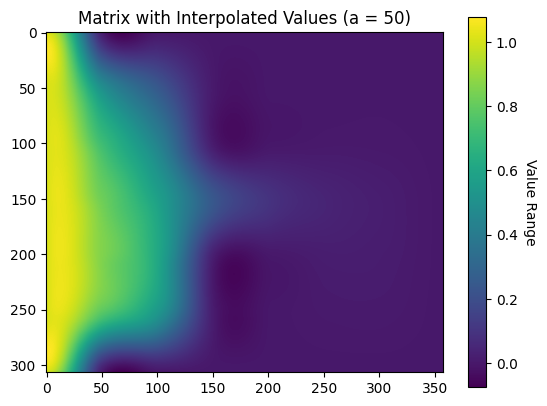

In [111]:
import matplotlib.pyplot as plt

# Set the amplification factor for interpolation
amplification_factor = 50

# Generate an amplified matrix with interpolated values using the bicubic splines method
interpolated_matrix = amplification_matrix(matrix_values, amplification_factor)

# Generate labels for x-axis and y-axis
x_labels = [f"x{i}" for i in range(len(interpolated_matrix[0]))]
y_labels = [f"y{i}" for i in range(len(interpolated_matrix))]

# Plot the interpolated matrix
fig, ax = plt.subplots()
im = ax.imshow(interpolated_matrix)

# # Add labels to the axes
# ax.set_xticks(np.arange(len(x_labels)))
# ax.set_yticks(np.arange(len(y_labels)))

# Add colorbar legend
colorbar = ax.figure.colorbar(im, ax=ax)
colorbar.ax.set_ylabel("Value Range", rotation=-90, va="bottom")

# Set the plot title
plot_title = f"Matrix with Interpolated Values (a = {amplification_factor})"
plt.title(plot_title)
plt.show()
